# DTSA-5509 Final Project: Predicting Heart Disease From CDC Survey Data
## April 24, 2022

## Introduction
This is the final project for DTSA-5509, Introduction to Machine Learning: Supervised Learning.  

According to the United States Center for Disease Control, CDC, [heart disease is the leading cause of death in the United States](https://www.cdc.gov/heartdisease/index.htm). Additionally, because heart disease may be “silent” and not diagnosed until a person experiences signs or symptoms of heart disease, several different scoring mechanisms have been developed to predict a person's risk of currently having it or getting it in the future ([one example](https://www.healthy-heart.org/keep-your-heart-healthy/predicting-managing-risk-of-heart-disease/)).
  
This project attempts to predict whether or not a person currently has heart disease based on [the 2020 annual CDC survey data of 400k adults related to their health status](https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease)

This Jupyter notebook along with the data used to create report can be found at and cloned from https://github.com/clayv/DTSA-5509_Final.

In [2]:
from imblearn.over_sampling import SMOTE
import matplotlib.pylab as plt
import pandas as pd
import seaborn as sns
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics 
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

#Set a global random state (set to 'None' if reproducible results are not desired)
randomState = 42

## Loading the Data, Initial Examination, and Data Cleaning
First we'll load the data and take an initial look at how it is formated.

In [3]:
df = pd.read_csv("data/heart_2020_cleaned.csv.zip", compression="zip")
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


In [4]:
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  object 
 3   AlcoholDrinking   319795 non-null  object 
 4   Stroke            319795 non-null  object 
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  object 
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  object 
 12  PhysicalActivity  319795 non-null  object 
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  object 
 16  KidneyDisease     31

,BMI,PhysicalHealth,MentalHealth,SleepTime
count,319795.000000,319795.00000,319795.000000,319795.000000
mean,28.325399,3.37171,3.898366,7.097075
std,6.356100,7.95085,7.955235,1.436007
min,12.020000,0.00000,0.000000,1.000000
25%,24.030000,0.00000,0.000000,6.000000
50%,27.340000,0.00000,0.000000,7.000000
75%,31.420000,2.00000,3.000000,8.000000
max,94.850000,30.00000,30.000000,24.000000


The initial examination indicates that some data cleaning, such as converting the 'Yes', 'No' strings to True, False values and converting others to categories (e.g. "Race"), will be required.

In [5]:
def CleanColumn(col):
    if df[col].unique().all() in ['No', 'Yes']:
        df[col] = df[col].map({'Yes':True ,'No':False}).astype(bool)
    else:
        df[col] = df[col].astype("category")
    
for col in df.columns:
    if df[col].dtype == 'object':
        CleanColumn(col)


Additionally, the maximum values for both "BMI" (Body Mass Index) and typical nightly "SleepTime" (measured in hours) 
seem too high and the plots below show a heavy skew to the left. Those values will get capped at 70 and 19 respectively to reduce the work the machine learning algorithms will need to do.

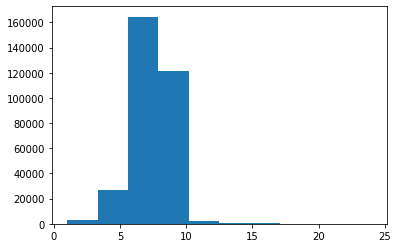

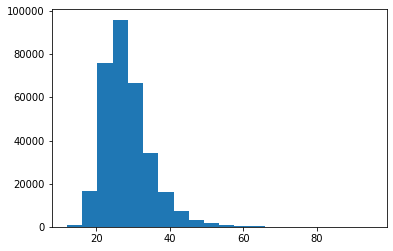

In [6]:
#print(df.SleepTime.value_counts())
plt.hist(df.SleepTime)
plt.show()
plt.hist(df.BMI, 20)
plt.show()

In [7]:
print("Before caping:")
print("Count of 19 or more hours Sleep Time: {}".format(len(df[(df.SleepTime >= 19)])))
print("Count of BMI 70 or greater: {}\n".format(len(df[(df.BMI >= 70)])))
df.SleepTime = df.SleepTime.where(df.SleepTime <= 19, 19)
df.BMI = df.BMI.where(df.BMI <= 70, 70)
#df.SleepTime = df.SleepTime.astype("category")
print("After capping:")
print("Count of Sleep Time exactly 19: {}".format(len(df[(df.SleepTime == 19)])))
print("Count of BMI exactly 70: {}".format(len(df[(df.BMI == 70)])))


Before caping:
Count of 19 or more hours Sleep Time: 111
Count of BMI 70 or greater: 129

After capping:
Count of Sleep Time exactly 19: 111
Count of BMI exactly 70: 129


## Exploratory Data Analysis
As this is predicting disease, it is expected that the data set will not be balanced between the True and False values for "HeartDisease".  The next cell confirms this, so the classifier chosen will need to work well with unblanced data, or methods of balancing the data will be required, or perhaps both can be used.

In [8]:
df.HeartDisease.value_counts()

False    292422
True      27373
Name: HeartDisease, dtype: int64

Violin plots of the numeric fields show that the values do not differ across features greatly in magnitiude or range, so no standardization will be performed.

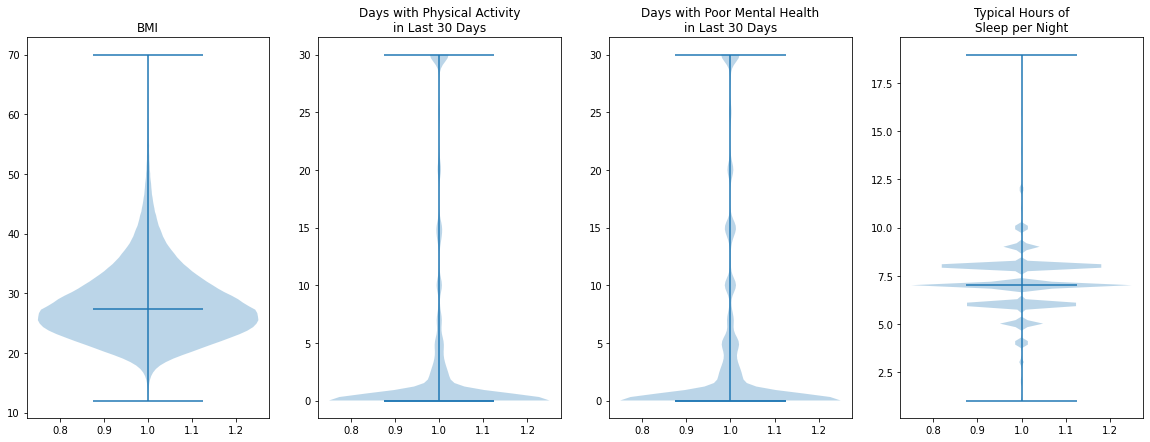

In [9]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows = 1, ncols = 4)

ax1.violinplot(df.BMI, showmedians = True)
ax1.set_title('BMI')

ax2.violinplot(df.PhysicalHealth, showmedians = True)
ax2.set_title('Days with Physical Activity\nin Last 30 Days')

ax3.violinplot(df.MentalHealth, showmedians = True)
ax3.set_title('Days with Poor Mental Health\nin Last 30 Days')

ax4.violinplot(df.SleepTime, showmedians=True)
ax4.set_title('Typical Hours of\nSleep per Night')

fig.set_figheight(7)
fig.set_figwidth(20)
plt.show()


The pairwise correlation of columnns shows almost no correlation as the highest value seen in the heatmap below is .43. The lack of correlated features indicates that the entire feature set can potentially be used in the classifiers.

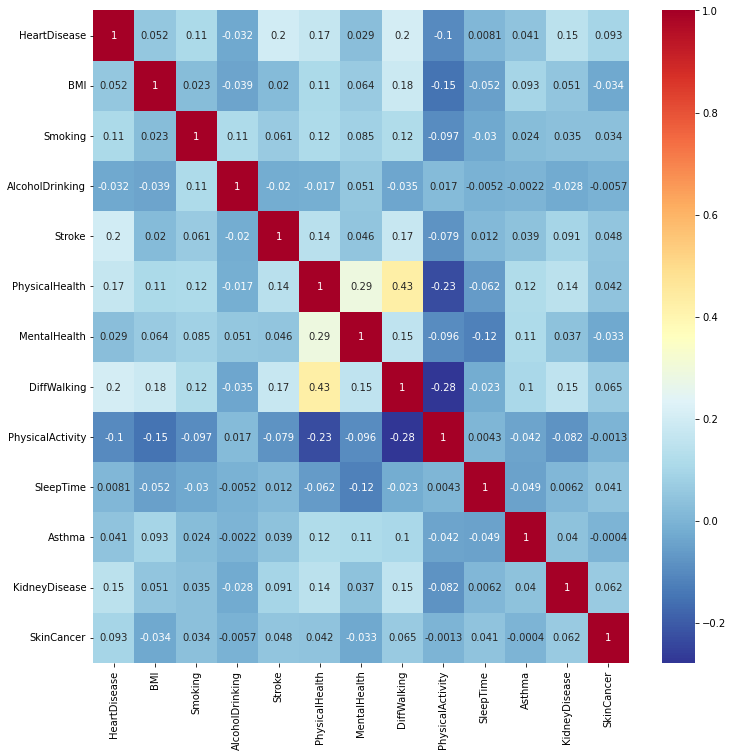

In [12]:
plt.figure(figsize = (12, 12))
sns.heatmap(df.corr(), annot = True, cmap = "RdYlBu_r")
plt.show()


## Model Building and Training
To prepare the categories in the data set for the classifier, two different techniques are used.  For nominal categories, "Sex" and "Race", a simple encoder is used.  The "AgeCategory", "Diabetic", and "GenHealth" categories are ordinal values and in order to preserve this ranking for the classifier mapping dictionaries are used for each category.  
  
The final format of the data is displayed also diplayed.

In [10]:
df = pd.get_dummies(df, columns=['Sex', 'Race'], prefix = ['Gender', 'Race'])

ageDict = {'18-24':1, '25-29':2, '30-34':3, '35-39':4, '40-44':5, '45-49':6, '50-54':7, 
           '55-59':8, '60-64':9, '65-69':10, '70-74':11, '75-79':12, '80 or older':13}
diabeticDict = {'No':1, 'No, borderline diabetes':2, 'Yes (during pregnancy)':3, 'Yes':4}
healthDict = {'Poor':1, 'Fair':2, 'Good':3, 'Very good':4, 'Excellent':5}

df['AgeCategory']= df.AgeCategory.map(ageDict)
df['Diabetic']= df.Diabetic.map(diabeticDict)
df['GenHealth']= df.GenHealth.map(healthDict)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 24 columns):
 #   Column                               Non-Null Count   Dtype   
---  ------                               --------------   -----   
 0   HeartDisease                         319795 non-null  bool    
 1   BMI                                  319795 non-null  float64 
 2   Smoking                              319795 non-null  bool    
 3   AlcoholDrinking                      319795 non-null  bool    
 4   Stroke                               319795 non-null  bool    
 5   PhysicalHealth                       319795 non-null  float64 
 6   MentalHealth                         319795 non-null  float64 
 7   DiffWalking                          319795 non-null  bool    
 8   AgeCategory                          319795 non-null  category
 9   Diabetic                             319795 non-null  category
 10  PhysicalActivity                     319795 non-null  bool    
 11  

### Test/Training Split and Data Augmentation with SMOTE
The data set will be split into training and testing sets with respective share of 2/3 and 1/3 of the data. Additionally, [Synthetic Minority Over-sampling Technique](https://www.cs.cmu.edu/afs/cs/project/jair/pub/volume16/chawla02a-html/chawla2002.html), "SMOTE", will be used to augment the **training data only**.  Augmenting the data was found to be beneficial even when using tree based classifiers.


In [11]:
y = df.HeartDisease.values
X = df.drop('HeartDisease', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = randomState)

X_train, y_train = SMOTE().fit_resample(X_train, y_train)

### Classifier Evaluation
Tree based classifiers work well with imbalanced data and even though the data has been augmented, I decided to evaluate tree based classifiers for this project, specifically a Random Forest and an AdaBoosted classifier.

In [12]:
rfModel = RandomForestClassifier().fit(X_train, y_train)
y_predRF = rfModel.predict(X_test)

#dtClf = DecisionTreeClassifier(max_depth = 1, class_weight = "balanced")
boostModel = AdaBoostClassifier(n_estimators = 50, algorithm='SAMME.R', random_state = randomState).fit(X_train, y_train)
y_predBoost = boostModel.predict(X_test)


## Results
### Random Forest Results 

Accuracy: 0.8988373305032549
Precision: 0.3212447356106692
Recall: 0.15008745080891997
F1 score: 0.20458947995827742
Area Under Curve: 0.7901208621714325

Confusion Matrix:
[[93484  2901]
 [ 7775  1373]]


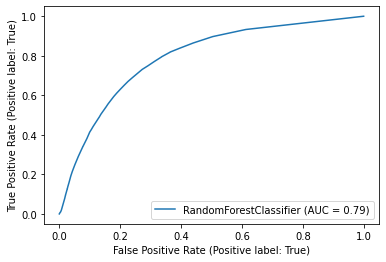

In [15]:
print("Accuracy: {}".format(metrics.accuracy_score(y_test, y_predRF)))
print("Precision: {}".format(metrics.precision_score(y_test, y_predRF, pos_label = True)))
print("Recall: {}".format(metrics.recall_score(y_test, y_predRF, pos_label = True)))
print("F1 score: {}".format(metrics.f1_score(y_test, y_predRF)))
print("Area Under Curve: {}".format(metrics.roc_auc_score(y_test, [p[1] for p in rfModel.predict_proba(X_test)])))
print("\nConfusion Matrix:")
print(metrics.confusion_matrix(y_test, y_predRF))
_ = metrics.RocCurveDisplay.from_estimator(rfModel, X_test, y_test)

### AdaBoost Decision Tree Results 


Accuracy: 0.854168838183317
Precision: 0.29322909765469723
Recall: 0.48382160034980326
F1 score: 0.3651513901493276
Area Under ROC: 0.812584749585128

Confusion Matrix:
[[85717 10668]
 [ 4722  4426]]


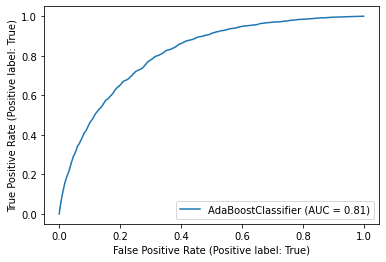

In [16]:
print("Accuracy: {}".format(metrics.accuracy_score(y_test, y_predBoost)))
print("Precision: {}".format(metrics.precision_score(y_test, y_predBoost, pos_label = True)))
print("Recall: {}".format(metrics.recall_score(y_test, y_predBoost, pos_label = True)))
print("F1 score: {}".format(metrics.f1_score(y_test, y_predBoost)))
print("Area Under ROC: {}".format(metrics.roc_auc_score(y_test, [p[1] for p in boostModel.predict_proba(X_test)])))
print("\nConfusion Matrix:")
print(metrics.confusion_matrix(y_test, y_predBoost))
_ = metrics.RocCurveDisplay.from_estimator(boostModel, X_test, y_test)

## Discussion and Conclusion
Although both the Random Forest and AdaBoost classifiers have very similar Accuracy (.899 vs. .854), Precision (.321 vs .293, and AUROC scores (.790 vs. .813), AdaBoost has a much better Recall (.150 vs. .484) and F1 (.205 vs. .365) score.  
  
To review, Recall is calculated as:  
$True\ Positive\ /\ (True\ Positive + False\ Negative)$  
and F1 is calculated as:  
$2 \times True\ Positive\ /\ ((2 \times True\ Positive) + False\ Positive + False\ Negative)$
  
If the confusion matrices are compared, AdaBoost's improved Recall and F1 scores are essentially due to classifications being moved from Predicted False column directly to the right into the Predicted True column. This results into higher False Positives and well as True Positives being classified.  The use of the AdaBoost classifier would result in many more people having perhaps additional tests being ordered to determine if they do indeed have heart disease, but given that heart disease is the number one cause of death in the United States, the trade off for 39.2% reduction in False Negatives, which in this case  means someone would have heart disease but be classified as not and therefore putting their life in jeopardy, seems worthwhile.